<a href="https://colab.research.google.com/github/ceccaroni1884368/Face-to-BMI/blob/main/Face_To_BMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Libraries

In [1]:
! pip install autocrop -q
! pip install facenet-pytorch -q

In [2]:
import os
from bs4 import BeautifulSoup
import requests
import autocrop
from tqdm import tqdm
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import autocrop
import torch
import torchvision
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Download static files

* pages_list.txt: file contenente i link delle pagine web necessari per il dataset
* list_images.txt: lista di immagini ispezionate visivamente

In [3]:
! wget -q -O list_images.txt https://drive.google.com/u/1/uc?id=1rH9lhUKIbqFOD5U9EmEFTT-0sw6lMLIT&export=download
! wget -q -O pages_list.txt https://drive.google.com/u/1/uc?id=1rLoLuDkmrBRhIH4DoTDn3iAX4G4d7ydw&export=download

# Dataset

Per creare il dataset viene eseguito uno web scraping del sito https://compareceleb.com/ e vengono salvati i valori dell'altezza (H) in cm del peso (W) in kg e viene scaricata l'immagine contenente il volto.

Successivamente viene calcolato il BMI con la formula

$$
BMI = \frac{ W }{(H / 100)^2}
$$


In [4]:
# Load list of web pages
with open(os.path.join('.', 'pages_list.txt')) as f:
    pages_list = f.read().splitlines()

output_dir = os.path.join('.', 'dataset')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Web scraping e creazione del Dataset

In [5]:
images = []
heights = []
weights = []

for i in tqdm(range(len(pages_list))):
    html_page = requests.get(pages_list[i])
    soup = BeautifulSoup(html_page.text, "html.parser")

    # image
    for x in soup.findAll('img'):
        if '.jpg' in x['src']:
            images.append(x['src'])
            break

    # height and weight
    h = False
    w = False
    for x in soup.findAll('td'):
        if h:
            heights.append(float(x.text.split()[0]))
        if w:
            weights.append(float(x.text.split()[0]))

        if 'Height' in x.text:
            h = True
            w = False 
        elif 'Weight' in x.text:
            h = False
            w = True
        else:
            h = False
            w = False
            
    l = min([len(images), len(heights), len(weights)])
    images = images[:l]
    heights = heights[:l]
    weights = weights[:l]

100%|██████████| 2001/2001 [09:30<00:00,  3.50it/s]


In [6]:
df = pd.DataFrame({'image':images, 'height (cm)': heights, 'weight (kg)': weights})
df.head()

,image,height (cm),weight (kg)
0,https://compareceleb.com/uploads/posts/2017-04...,167.0,66.0
1,https://compareceleb.com/uploads/posts/2018-08...,163.0,58.0
2,https://compareceleb.com/uploads/posts/2018-08...,166.0,56.0
3,https://compareceleb.com/uploads/posts/2018-08...,168.0,54.0
4,https://compareceleb.com/uploads/posts/2018-08...,180.3,84.0


## Download delle immagini

In [7]:
images_path = os.path.join(output_dir, 'images')
if not os.path.exists(images_path):
    os.makedirs(images_path)

for image in tqdm(df['image']):
    response = requests.get(image)

    file = open(os.path.join(output_dir, 'images',image.split('/')[-1].split('_')[0]+ '.jpg'), "wb")
    file.write(response.content)
    file.close()

100%|██████████| 1973/1973 [02:22<00:00, 13.89it/s]


In [8]:
df['image'] = df['image'].apply(lambda x: x.split('/')[-1].split('_')[0] + '.jpg')

In [9]:
# list of "good" images
with open(os.path.join('.', 'list_images.txt')) as f:
    list_images = f.read().splitlines()

## Salvataggio Dataset in csv

In [10]:
df = df[df['image'].isin(list_images)]
df = df.reset_index(drop=True)
df.to_csv(os.path.join(output_dir, 'df.csv'), index=False)

In [11]:
df = pd.read_csv(os.path.join(output_dir, 'df.csv'))

## Esplorazione dei dati

### BMI

In [12]:
df['BMI'] = df['weight (kg)'] / (df['height (cm)'] /100)**2
df.head()

,image,height (cm),weight (kg),BMI
0,1491379716.jpg,167.0,66.0,23.665244
1,1533303278.jpg,163.0,58.0,21.829952
2,1533305289.jpg,166.0,56.0,20.322253
3,1533306129.jpg,168.0,54.0,19.132653
4,1533306989.jpg,180.3,84.0,25.839722


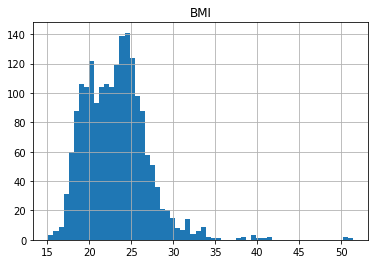

In [13]:
df[['BMI']].hist(bins=60)
plt.show()

I soggetti vengono poi classificati come **underweight** se  $BMI < 18.5$, **normal** se $18.5 \le BMI < 25$, **overweight** se $25 \le BMI < 30$,
**moderately obese** se $30 \le BMI < 35$, **severely obese** se $35 \le BMI < 40$ e **very severely obese** se $BMI >= 40$.

In [14]:
def bmi_classification(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif (bmi >= 18.5) and (bmi < 25):
        return 'normal'
    elif (bmi >= 25) and (bmi < 30):
        return 'overweight'
    elif (bmi >= 30) and (bmi < 35):
        return 'moderately obese'
    elif (bmi >= 35) and (bmi < 40):
        return 'severely obese'
    else:
        return 'very severely obese'

In [15]:
df['class'] = df['BMI'].apply(bmi_classification)

In [16]:
df['class'].value_counts()

normal                 1221
overweight              457
underweight             161
moderately obese         58
very severely obese       7
severely obese            7
Name: class, dtype: int64

# Modello

In questo paragrafo verranno utilizzati:

* MTCNN: pre-trained Convolution Neural Network per estrarre i volti dalle immagini
* FaceNet (InceptionResnetV1): pre-trained Convolution Neural Network per estrarre le features (512) dalle immagini
* SVR: Support Vector Machine per la regressione  

In [17]:
mtcnn = MTCNN()
resnet = InceptionResnetV1(pretrained='vggface2', classify=False).eval()

## Estrazione delle features

In [18]:
images_features = []
images_targets = []
images_paths = []
for i in tqdm(range(len(df['image']))):
    path = os.path.join(images_path, df['image'].iloc[i])
    img = Image.open(path)
    try:
        # Get cropped and prewhitened image tensor
        img_cropped = mtcnn(img)

        # Calculate embedding (unsqueeze to add batch dimension)
        img_embedding = resnet(img_cropped.unsqueeze(0))

        images_features.append(img_embedding.detach().cpu().numpy().flatten())
        images_targets.append(df['BMI'].iloc[i])
        images_paths.append(df['image'].iloc[i])
    except:
        pass

df_new = pd.DataFrame(images_features)
df_new['target'] = images_targets
df_new['path'] = images_paths
df_new.to_csv(os.path.join(output_dir, 'df_features.csv'), index=False)

100%|██████████| 1911/1911 [11:25<00:00,  2.79it/s]


## Dataset Finale

In [19]:
df_new = pd.read_csv(os.path.join(output_dir, 'df_features.csv'))

In [20]:
df_new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,target,path
0,-0.028471,-0.130453,0.003422,0.026207,0.054758,-0.010963,0.067463,-0.001257,0.025006,0.013459,-0.046405,0.009653,0.055557,0.057967,-0.010518,0.055098,-0.080426,0.007287,0.016003,-0.023037,-0.077386,0.069949,0.018376,0.011975,0.012924,-0.072431,-0.059114,-0.101506,-0.019967,-0.052042,0.059195,0.052795,0.088112,-0.006731,0.078733,0.022323,0.007562,0.035845,-0.072146,-0.012514,...,-0.038055,0.046773,-0.014872,-0.065536,0.087629,0.065342,0.000720,-0.041747,-0.032527,-0.081531,0.050887,-0.034693,0.035352,-0.038900,0.011833,-0.000612,-0.029266,-0.030287,0.091838,-0.045014,0.046868,0.001323,0.004895,0.047511,0.023782,-0.011367,0.052257,-0.054884,0.029280,0.035506,-0.000348,0.004212,0.044798,-0.044689,0.039541,-0.028976,-0.088558,-0.012699,23.665244,1491379716.jpg
1,-0.092052,0.018627,0.007877,-0.041999,-0.005861,0.038907,-0.019004,-0.022388,-0.022027,0.062294,-0.003876,0.045918,-0.037317,-0.075878,0.047064,-0.017867,0.029779,-0.007833,-0.070748,-0.030079,-0.070942,0.053401,-0.027637,0.016629,-0.019329,0.037372,-0.045799,-0.010112,0.008457,0.019493,-0.057346,0.057563,0.002163,0.005674,-0.051516,0.055615,0.014703,-0.064435,-0.003139,0.023917,...,-0.013165,-0.006028,-0.011632,-0.001265,-0.005124,-0.035801,0.061926,-0.008659,0.017467,-0.045162,0.071220,-0.006332,-0.055087,-0.100227,-0.046037,-0.000901,-0.033449,0.020763,0.003958,0.003150,0.014266,-0.056904,-0.049141,-0.003196,-0.031207,0.068938,-0.097217,0.006730,0.028291,0.034134,0.047746,0.000396,-0.048632,0.004430,0.109743,-0.018073,-0.000559,0.009812,21.829952,1533303278.jpg
2,-0.018705,0.072215,0.007546,-0.095771,0.021259,0.057256,-0.062290,0.016131,0.039233,0.001925,-0.059607,0.042652,0.008355,-0.045719,-0.011055,-0.011898,0.022722,-0.058477,-0.073742,-0.055248,-0.060769,0.080319,0.034011,0.038355,0.007856,0.024356,0.002261,0.016015,-0.040430,0.007524,-0.060169,0.060637,0.031955,-0.032345,-0.012959,0.087907,0.058439,-0.007256,-0.009601,-0.050376,...,-0.018639,-0.014995,0.013569,-0.020686,-0.010287,-0.054720,0.063875,0.041881,-0.014865,-0.086650,0.006097,-0.033488,0.029950,-0.058993,-0.030917,0.030727,0.056141,0.018375,0.017032,-0.028414,-0.000716,0.001417,-0.077361,-0.006971,-0.042697,0.027709,-0.060122,0.036257,0.021823,0.008237,0.085843,-0.049708,-0.052487,-0.044679,0.081969,0.022784,0.003549,0.004035,20.322253,1533305289.jpg
3,-0.017358,0.055324,-0.023903,-0.052602,-0.030108,0.013327,-0.015151,0.058731,-0.000408,0.036150,-0.003820,0.005928,-0.025573,-0.025115,0.009362,0.000933,0.047360,0.032709,-0.057080,-0.108250,0.023307,-0.002242,0.018620,0.043381,-0.009989,-0.083530,-0.064895,0.011271,-0.035838,-0.009148,-0.018304,0.004655,0.044884,-0.036144,0.007571,0.080642,0.038030,-0.043986,0.021415,-0.042445,...,0.001000,-0.052518,-0.063584,0.014968,0.044935,-0.064571,0.009992,-0.043703,0.023606,-0.087894,-0.058310,0.004256,-0.008352,-0.083440,0.027324,-0.043257,0.018682,-0.049171,0.002571,-0.023714,0.007737,-0.038105,-0.021210,0.021628,-0.063713,0.060064,-0.080092,-0.014358,0.077442,0.075566,0.041063,0.027353,-0.023984,0.063414,0.044977,-0.053337,-0.082705,-0.058147,19.132653,1533306129.jpg
4,0.086870,-0.054204,-0.040870,-0.082846,-0.057620,-0.001260,0.007474,-0.000883,-0.087843,0.010113,-0.010380,0.035335,0.024748,-0.017007,0.053944,-0.082208,0.024722,-0.014433,0.007435,0.009175,0.000944,-0.023711,0.065773,0.047138,0.042660,0.010646,-0.018250,0.026027,0.077195,0.034615,0.009093,-0.084705,-0.052524,0.027934,-0.000151,-0.040842,-0.071697,0.035392,0.034372,0.013245,...,0.006157,-0.015027,0.075037,-0.058522,-0.052540,0.030310,0.045348,0.031488,0.026857,0.009538,-0.013102,-0.004044,-0.039061,0.009824,0.021131,0.015023,-0.093279,-0.017715,-0.035465,-0.022495,0.023429,0.021882,-0.034307,0.039946,-0.035032,0.046141,-

In [21]:
df_test = df_new.sample(frac=0.002, random_state=1884368)[['path', 'target']]
df_new = df_new.drop(df_test.index).reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Data pre-processing

### Scaler

In [22]:
sc_X = MinMaxScaler()
sc_y = MinMaxScaler()
X = sc_X.fit_transform(df_new.drop(['target', 'path'], axis=1).to_numpy())
y = sc_y.fit_transform(df_new['target'].to_numpy().reshape(-1,1)).flatten()

### Train and Test set splitting

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SVR Model

In [24]:
svr = SVR(kernel='rbf', C=0.2, epsilon=0.01)
_ = svr.fit(X_train, y_train)

In [25]:
print(f'R2 Score: {svr.score(X_test, y_test)}')
print(f'Correlation: {svr.score(X_test, y_test)**(1/2)}')

R2 Score: 0.44001379658658407
Correlation: 0.6633353575579882


# Test

In [26]:
def test_image(path):
    img = Image.open(path)
    try:
        # Get cropped and prewhitened image tensor
        img_cropped = mtcnn(img)

        # Calculate embedding (unsqueeze to add batch dimension)
        img_embedding = resnet(img_cropped.unsqueeze(0))

        images_features = img_embedding.detach().cpu().numpy().flatten()
        
        images_features = sc_X.transform(images_features.reshape(1,-1))

        predict = svr.predict(images_features)
        predict = sc_y.inverse_transform(predict.reshape(-1,1))

        plt.imshow(img)
        plt.show()
        print(f'Predicted BMI: {round(predict.flatten()[0],2)}')
    except:
        print('Face not found')

## ...on a small test dataset

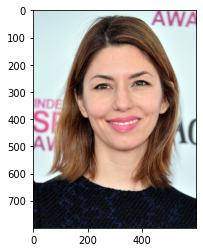

Predicted BMI: 19.02
True BMI: 19.38097176192414


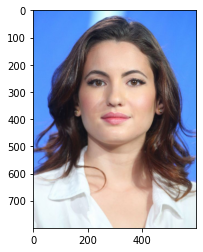

Predicted BMI: 21.45
True BMI: 20.028841531805803


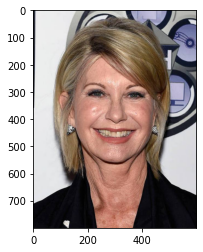

Predicted BMI: 21.71
True BMI: 20.29209220726699


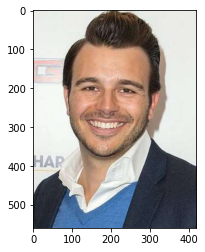

Predicted BMI: 22.97
True BMI: 22.63467632412857


In [27]:
for i in range(len(df_test['path'])):
    img_path = os.path.join('.', 'dataset', 'images', df_test['path'].iloc[i])
    test_image(img_path)
    print('True BMI:', df_test['target'].iloc[i])

## ...uploading a photo

In [ ]:
img_path = files.upload()
img_path = list(img_path.keys())[0]
test_image(img_path)

## ...taking a picture

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  img_path = filename

  test_image(img_path)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))